# XRD Clustering With NMF / SOM

1. Dimensionality reduction using NMF.
2. Clustering using self organizing maps.

In [1]:
# imports

import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.decomposition import NMF
from minisom import MiniSom
import pandas as pd

In [2]:

path = r"D:\Masters project\DiffractionImages\run264369-0.h5"
datafile = r"D:\ml_data.dat"

# Target shape for ML (Much smaller than 1700x1700)
# 128x128 = 16,384 features (manageable for SOM/NMF)
TARGET_SHAPE = (128, 128) 


In [3]:

def stream_and_resize(filename, target_shape):
    with h5py.File(filename, "r") as f:
        keys = [k for k in f.keys() if k != "metadata" and "data" in f[k]]
        for key in keys:
            data = f[key]["data"][()]
            # Log scale helps with high dynamic range of XRD
            data_log = np.log1p(np.abs(data)) 
            # Resize (anti-aliasing preserves peaks)
            data_resized = resize(data_log, target_shape, anti_aliasing=True)
            yield data_resized.flatten()

# Count items to initialize memmap
with h5py.File(path, 'r') as f:
    num_items = len([k for k in f.keys() if k != "metadata" and "data" in f[k]])

# Calculate flat feature size
feature_size = TARGET_SHAPE[0] * TARGET_SHAPE[1]

# Create memmap with float32 (standard for ML)
X_mm = np.memmap(datafile, dtype='float32', mode='w+', shape=(num_items, feature_size))

print("Processing and resizing images...")
for i, sample in enumerate(stream_and_resize(path, TARGET_SHAPE)):
    X_mm[i] = sample
    if i % 100 == 0: print(f"Processed {i}/{num_items}")

# Flush changes to disk
X_mm.flush()

Processing and resizing images...
Processed 0/2718
Processed 100/2718
Processed 200/2718
Processed 300/2718
Processed 400/2718
Processed 500/2718
Processed 600/2718
Processed 700/2718
Processed 800/2718
Processed 900/2718
Processed 1000/2718
Processed 1100/2718
Processed 1200/2718
Processed 1300/2718
Processed 1400/2718
Processed 1500/2718
Processed 1600/2718
Processed 1700/2718
Processed 1800/2718
Processed 1900/2718
Processed 2000/2718
Processed 2100/2718
Processed 2200/2718
Processed 2300/2718
Processed 2400/2718
Processed 2500/2718
Processed 2600/2718
Processed 2700/2718


In [4]:

# Just read the first item to check shape
datafile = r"D:\ml_data.dat"
test_mm = np.memmap(datafile, dtype='float32', mode='r')
print(f"Total size on disk: {test_mm.shape}")

Total size on disk: (44531712,)


In [5]:
# Load Data
datafile = r"D:\ml_data.dat"
# We calculated this from your file size:
num_items = 2718 
feature_size = 128 * 128  # 16384

# Load the resized data
X = np.memmap(datafile, dtype='float32', mode='r', shape=(num_items, feature_size))
print(f"Data loaded: {X.shape}")

Data loaded: (2718, 16384)


In [6]:

# NMF
# This converts pixels to crystal phases

n_components = 5  # Number of phases + background?
nmf = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=500)

# W (How much of each phase is in each image)
W = nmf.fit_transform(X) 
# H (The actual diffraction patterns of the phases)
H = nmf.components_

print("NMF Complete.")


c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF Complete.


In [7]:

# SOM on the NMF Weights
# Cluster the "Recipes", not the pixels.
# W.shape[1] is the input dimension (16k pixels). sigma = 1.0: Neighbourhood radius. learning_rate = 0.5: controls how much the map changes in the beginning

som_dim = 10
som = MiniSom(som_dim, som_dim, W.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(W)
som.train_random(W, 10000) 
print("SOM Complete.")


SOM Complete.


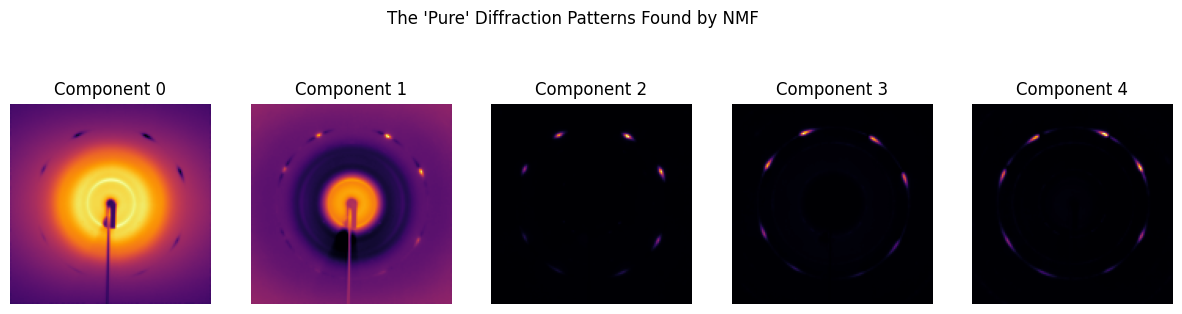

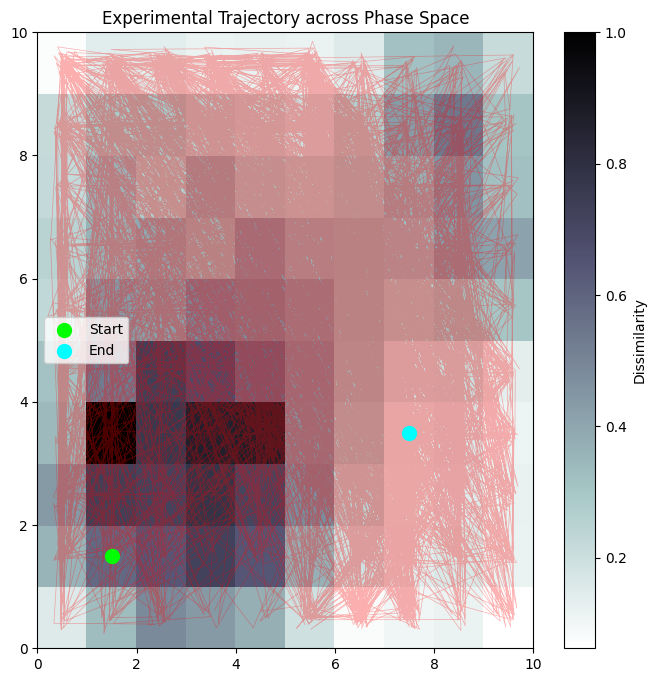

In [8]:

# Visualizing the Components
# NMF (Background vs Crystal Rings)
fig, axes = plt.subplots(1, n_components, figsize=(15, 4))
for i, ax in enumerate(axes):
    # Reshape the flat array back to 128x128 image
    img = H[i].reshape(128, 128)
    ax.imshow(img, cmap='inferno')
    ax.set_title(f'Component {i}')
    ax.axis('off')
plt.suptitle("The 'Pure' Diffraction Patterns Found by NMF")
plt.show()

# Visualizing the Trajectory (The Experiment)
# Map the experiment path (Image 0 - 2718) onto the SOM
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # Plot distance map
plt.colorbar(label='Dissimilarity')

# Calculate coordinates for every image
coords = np.array([som.winner(x) for x in W])

# Add jitter so we can see the path clearly
jitter = np.random.randn(len(coords), 2) * 0.1
plt.plot(coords[:, 0] + 0.5 + jitter[:, 0], coords[:, 1] + 0.5 + jitter[:, 1], 
         c='red', alpha=0.3, linewidth=0.5)

# Mark Start/End
plt.scatter(coords[0, 0]+0.5, coords[0, 1]+0.5, c='lime', s=100, label='Start', zorder=10)
plt.scatter(coords[-1, 0]+0.5, coords[-1, 1]+0.5, c='cyan', s=100, label='End', zorder=10)

plt.legend()
plt.title("Experimental Trajectory across Phase Space")
plt.show()

In [9]:
#  Aiming to filter out 'grain noise' to reveal a clearer structural phase transition path. The raw trajectory is very noisy due to grain noise, making it hard to see the underlying phase transition path. By smoothing the NMF weights before retraining the SOM, we can reveal a clearer trajectory that better represents the actual phase changes occurring during the experiment.

# Smooth the NMF Weights
# Convert W (the NMF weights) to a DataFrame
df_W = pd.DataFrame(W)

# Apply a rolling window to average out the "flickering" spots
# Window size depends on your data speed. 
# If you have 2700 images, try a window of 50.
# For every time point, we average the weights of the 25 previous and 25 next points (total 50) to smooth out rapid fluctuations. This helps reveal the underlying trend in phase changes while reducing noise from grain fluctuations.
W_smoothed = df_W.rolling(window=50, center=True).mean().dropna()  # .dropna() removes the NaN values at the edges caused by rolling

# Drop the corresponding raw data indices too (since rolling removes edges)
# But for SOM training, we just need the smoothed weights.
W_smooth_numpy = W_smoothed.to_numpy()  # convert back to numpy array for SOM training

print(f"Original shape: {W.shape}")
print(f"Smoothed shape: {W_smooth_numpy.shape}")


Original shape: (2718, 5)
Smoothed shape: (2669, 5)


In [10]:

# Retrain SOM on SMOOTHED data
som_dim = 10  # reduced grid size from 20x20 to 10x10
som = MiniSom(som_dim, som_dim, W_smooth_numpy.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(W_smooth_numpy)
som.train_random(W_smooth_numpy, 10000) # map learns the trajectory of the phase, not the twinkling of the grains


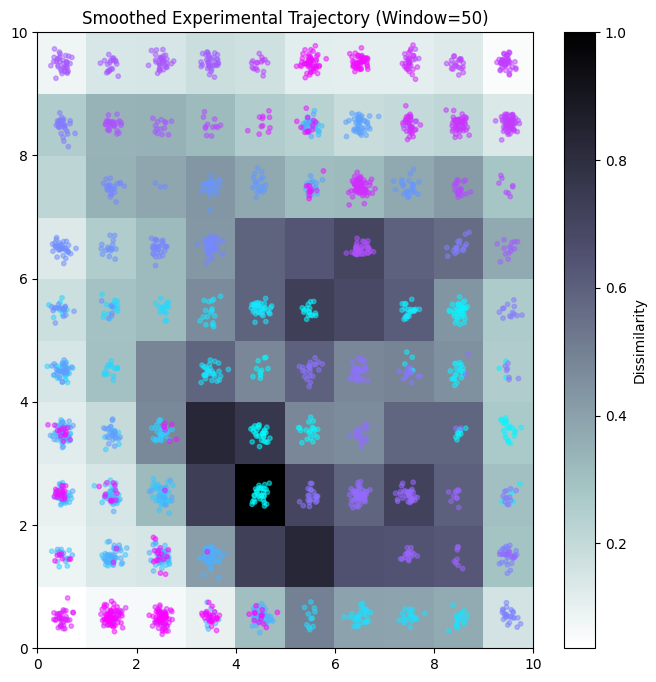

In [11]:

# Plot the Smoothed Trajectory
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r') 
plt.colorbar(label='Dissimilarity')

# Calculate coords for the smoothed path
coords = np.array([som.winner(x) for x in W_smooth_numpy])

# Less jitter needed now (smooth trajcetory)
jitter = np.random.randn(len(coords), 2) * 0.1

# Plotting with a gradient color to see time evolution (Blue -> Red)
# This helps distinguish start from end even if lines overlap
# c=range(len(coords)): colour dots based on their time index. Early points are blue, end are purple.
plt.scatter(coords[:, 0] + 0.5 + jitter[:, 0], coords[:, 1] + 0.5 + jitter[:, 1], 
            c=range(len(coords)), cmap='cool', s=10, alpha=0.5)

plt.title("Smoothed Experimental Trajectory (Window=50)")
plt.show()

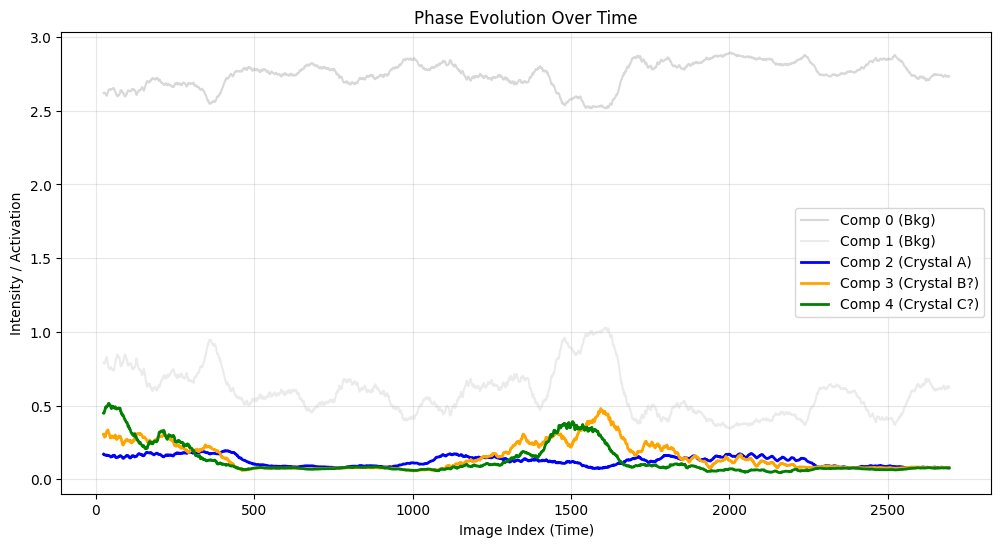

In [12]:
# Plotting the "Evolution of Phases"

# W contains the "amount" of each component in every image
# Shape: (2718, 5). Name the columns "Component i"
df_weights = pd.DataFrame(W, columns=[f"Component {i}" for i in range(5)])

# Apply rolling average to smooth out the "grain twinkling" noise
# Window = 50 images. removed high frequency grain noise but keeps the low frequency noise.
df_smooth = df_weights.rolling(window=50, center=True).mean()

# Plot
plt.figure(figsize=(12, 6))

# Plot all components to see which ones cross over
# Use standard colors to distinguish them
plt.plot(df_smooth['Component 0'], label='Comp 0 (Bkg)', color='gray', alpha=0.3)
plt.plot(df_smooth['Component 1'], label='Comp 1 (Bkg)', color='silver', alpha=0.3)

plt.plot(df_smooth['Component 2'], label='Comp 2 (Crystal A)', color='blue', linewidth=2)
plt.plot(df_smooth['Component 3'], label='Comp 3 (Crystal B?)', color='orange', linewidth=2)
plt.plot(df_smooth['Component 4'], label='Comp 4 (Crystal C?)', color='green', linewidth=2)

# label axes
plt.xlabel("Image Index (Time)")
plt.ylabel("Intensity / Activation")
plt.title("Phase Evolution Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()